In [174]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')  

In [175]:
# Model and data parameters
SEQUENCE_LENGTH = 128  # Sequence length for model input
BATCH_SIZE = 256       # Batch size for the data loader

MODEL_NAME = 'model_scalsers/RUL_biLSTM_R86.pth'  # Filename of the saved model

# Model parameters (must match the trained model)
LSTM_HIDDEN_SIZE1 = 350  # Hidden size of the first LSTM layer
LSTM_HIDDEN_SIZE2 = 150  # Hidden size of the second LSTM layer
LSTM_NUM_LAYERS = 5      # Number of LSTM layers (must match the trained model)
DROPOUT = 0.3            # Dropout rate

In [176]:
# Set device for computations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [177]:
# Load scalers
scaler_X = joblib.load('model_scalers/scaler_X.pkl')
scaler_Y = joblib.load('model_scalers/scaler_Y.pkl')

In [178]:
# Load test data
test_df = pd.read_csv('dataset/final_test.txt', sep=' ', header=None)
test_df.dropna(axis=1, inplace=True)

In [179]:
# Assign column names
columns = ['unit_number', 'time_in_cycles'] + \
          ['op_setting_1', 'op_setting_2', 'op_setting_3'] + \
          ['sensor_measurement_{}'.format(i) for i in range(1, 22)]

test_df.columns = columns

In [180]:
# Remove uninformative sensors
cols_to_drop = ['sensor_measurement_13', 'sensor_measurement_16', 'sensor_measurement_19']
feature_cols = ['op_setting_1', 'op_setting_2', 'op_setting_3'] + \
               [col for col in columns if 'sensor_measurement_' in col and col not in cols_to_drop]

INPUT_SIZE = len(feature_cols)

# Normalize features
test_df[feature_cols] = scaler_X.transform(test_df[feature_cols])

In [181]:
# Function to generate sequences using a sliding window
def gen_sequence_sliding_test(id_df, seq_length, seq_cols):
    """
    Generates fixed-length sequences for one engine using sliding windows.
    If the number of available cycles is less than seq_length, padding is added at the beginning of the sequence.

    Parameters:
    id_df (DataFrame): data for one engine
    seq_length (int): sequence length
    seq_cols (list): list of features

    Returns:
    seq_list (list): list of sequences
    mask_list (list): list of masks indicating valid data in the sequence
    """
    data_array = id_df[seq_cols].values 
    num_elements = data_array.shape[0]   
    seq_list = []   
    mask_list = []   
    
    if num_elements >= seq_length:
        # If there is enough data to form a full sequence
        for start in range(num_elements - seq_length + 1):
            seq = data_array[start:start + seq_length, :]  
            seq_list.append(seq)                          
            mask_list.append(np.ones(seq_length, dtype=np.float32))  
    else:
        # If data is less than seq_length, add padding
        pad_length = seq_length - num_elements  
        padded_seq = np.pad(data_array, ((pad_length, 0), (0, 0)), 'constant', constant_values=0)  
        seq_list.append(padded_seq)  
        mask = np.concatenate([np.zeros(pad_length, dtype=np.float32), np.ones(num_elements, dtype=np.float32)])  
        mask_list.append(mask)     
    
    return seq_list, mask_list  # Return lists of sequences and masks

In [182]:
# Generate sequences and masks for the test set
seq_array_test = [] 
mask_array_test = []  
engine_test = []  

# Iterate over each unique engine in the test data
for id in test_df['unit_number'].unique():
    id_df = test_df[test_df['unit_number'] == id] 
    seq_gen, mask_gen = gen_sequence_sliding_test(id_df, SEQUENCE_LENGTH, feature_cols)  
    if seq_gen:
        seq_array_test.extend(seq_gen)  
        mask_array_test.extend(mask_gen)  
        engine_test.extend([id] * len(seq_gen)) 

# Convert lists to numpy arrays for further processing
seq_array_test = np.array(seq_array_test)
mask_array_test = np.array(mask_array_test).astype(np.float32)
engine_test = np.array(engine_test)

In [183]:
# Create dataset and data loader for the test set
class TurbofanTestDataset(Dataset):
    def __init__(self, sequences, masks, engines):
        self.sequences = sequences  
        self.masks = masks          
        self.engines = engines     

    def __len__(self):
        return len(self.sequences)  

    def __getitem__(self, idx):
        # Return sequence, mask, and engine number by index
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32) 
        mask = torch.tensor(self.masks[idx], dtype=torch.float32)          
        engine = self.engines[idx]                                       
        return sequence, mask, engine

In [184]:
# Create an instance of the dataset for test data
test_dataset = TurbofanTestDataset(seq_array_test, mask_array_test, engine_test)

# Create data loader for the test set
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [185]:
# Define the model (must match the model during training)
class TurbofanModel(nn.Module):
    def __init__(self, input_size, dropout=0.3, lstm_hidden_size1=350, lstm_hidden_size2=150, lstm_num_layers=5):
        super(TurbofanModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(kernel_size=2)
        self.dropout1 = nn.Dropout(dropout)
        
        self.maxpool1_mask = nn.MaxPool1d(kernel_size=2)
        
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=lstm_hidden_size1, num_layers=lstm_num_layers,
                             batch_first=True, bidirectional=True, dropout=dropout)
        self.batch_norm1 = nn.BatchNorm1d(lstm_hidden_size1 * 2)
        self.dropout2 = nn.Dropout(dropout)
        
        self.lstm2 = nn.LSTM(input_size=lstm_hidden_size1 * 2, hidden_size=lstm_hidden_size2, num_layers=lstm_num_layers,
                             batch_first=True, bidirectional=True, dropout=dropout)
        self.batch_norm2 = nn.BatchNorm1d(lstm_hidden_size2 * 2)
        self.dropout3 = nn.Dropout(dropout)
        
        self.lstm3 = nn.LSTM(input_size=lstm_hidden_size2 * 2, hidden_size=25, num_layers=1,
                             batch_first=True, bidirectional=True, dropout=0.0)
        self.batch_norm3 = nn.BatchNorm1d(25 * 2)
        self.dropout4 = nn.Dropout(dropout)
        
        self.fc = nn.Linear(25 * 2, 1)

    def forward(self, x, mask):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        
        mask = mask.unsqueeze(1)
        mask = self.maxpool1_mask(mask)
        mask = mask.squeeze(1)
        mask = mask.unsqueeze(-1)
        
        x = x.permute(0, 2, 1)
        
        x, _ = self.lstm1(x)
        x = x.permute(0, 2, 1)
        x = self.batch_norm1(x)
        x = x.permute(0, 2, 1)
        x = self.dropout2(x)
        
        x, _ = self.lstm2(x)
        x = x.permute(0, 2, 1)
        x = self.batch_norm2(x)
        x = x.permute(0, 2, 1)
        x = self.dropout3(x)
        
        x, _ = self.lstm3(x)
        x = x.permute(0, 2, 1)
        x = self.batch_norm3(x)
        x = x.permute(0, 2, 1)
        x = self.dropout4(x)
        
        x = x * mask
        sum_x = torch.sum(x, dim=1)
        sum_mask = torch.sum(mask, dim=1)
        x = sum_x / (sum_mask + 1e-8)
        
        output = self.fc(x)
        return output.squeeze()

In [186]:
model = TurbofanModel(
    input_size=INPUT_SIZE,
    dropout=DROPOUT,
    lstm_hidden_size1=LSTM_HIDDEN_SIZE1,
    lstm_hidden_size2=LSTM_HIDDEN_SIZE2,
    lstm_num_layers=LSTM_NUM_LAYERS  
).to(device)

In [187]:
# Load the saved model
model.load_state_dict(torch.load(MODEL_NAME, map_location=device))
model.eval()
print("Model loaded and ready for prediction.")

Model loaded and ready for prediction.


In [188]:
# Prediction on test data
y_pred_test = []        
engine_test_list = []  

# Disable gradient computation for speed and memory efficiency
with torch.no_grad(): 
    for X_batch, mask_batch, engine_batch in test_loader:
        X_batch = X_batch.float().to(device)      
        mask_batch = mask_batch.float().to(device) 
        outputs = model(X_batch, mask_batch)       
        y_pred_test.extend(outputs.cpu().numpy())  
        engine_test_list.extend(engine_batch.numpy())  

In [189]:
# Reverse scaling of predictions
y_pred_test = np.array(y_pred_test)
engine_test_list = np.array(engine_test_list)

results_test = pd.DataFrame({
    'engine': engine_test_list,
    'y_pred': y_pred_test
})

In [190]:
# Inverse transformation using StandardScaler
results_test['y_pred_unscaled'] = scaler_Y.inverse_transform(results_test['y_pred'].values.reshape(-1, 1)).reshape(-1)

# For each engine, take the last prediction
final_predictions_test = results_test.groupby('engine').last().reset_index()

# Save predictions to file
final_output_test = final_predictions_test[['engine', 'y_pred_unscaled']].copy()
final_output_test.columns = ['unit_number', 'RUL']

# Save to CSV without indices
final_output_test.to_csv('final_test_predictions.csv', index=False)
print("Predictions saved in 'final_test_predictions.csv'.")

Predictions saved in 'final_test_predictions.csv'.


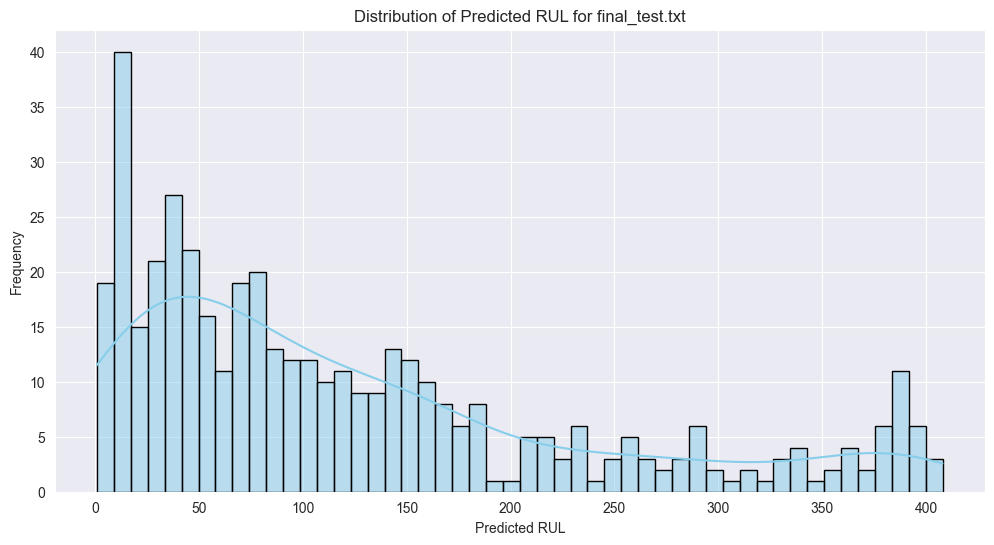

In [191]:
# Visualization of prediction distribution
plt.figure(figsize=(12, 6))
sns.histplot(final_output_test['RUL'], bins=50, kde=True, color='skyblue', edgecolor='k')
plt.title('Distribution of Predicted RUL for final_test.txt')
plt.xlabel('Predicted RUL')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [192]:
# Check maximum RUL values
print('Max predicted RUL:', final_predictions_test['y_pred_unscaled'].max())

Max predicted RUL: 407.84088


In [193]:
# Calculate average predicted RUL on the test set
avg_predicted_rul_test = final_predictions_test['y_pred_unscaled'].mean()
print(f"Average predicted RUL on the test set: {avg_predicted_rul_test:.2f}")

Average predicted RUL on the test set: 123.69


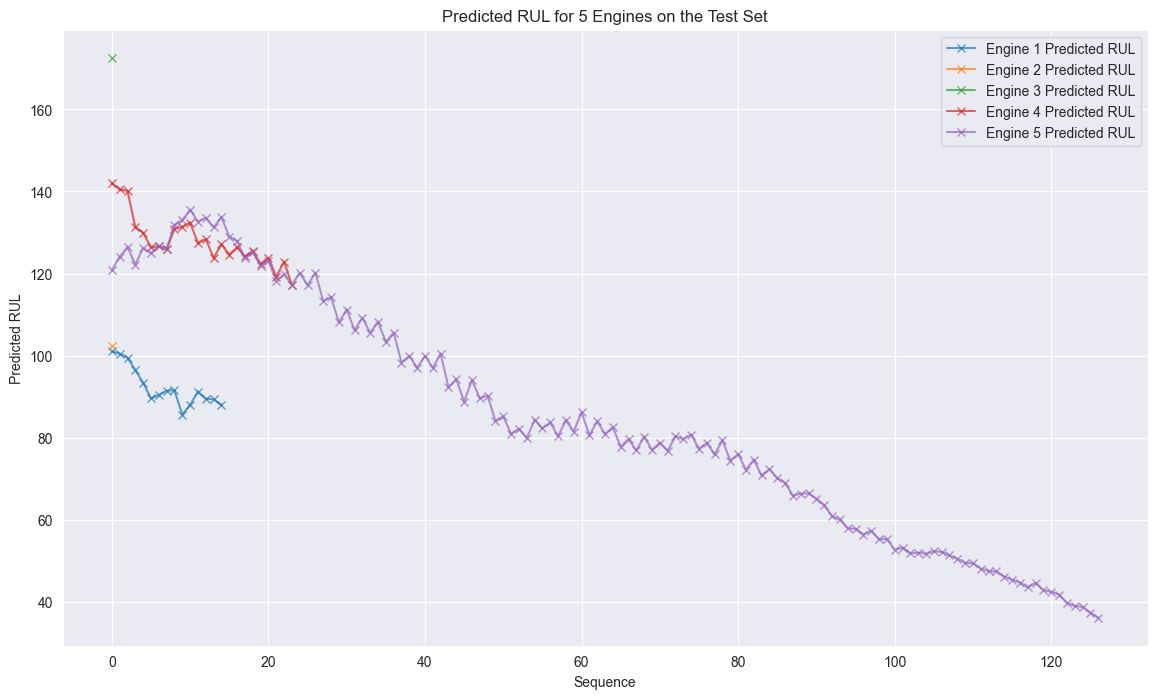

In [197]:
# Select 5 engines for detailed analysis
sample_engines_test = final_predictions_test['engine'].unique()[:5]
sample_results_test = results_test[results_test['engine'].isin(sample_engines_test)]

# Since we use sliding windows, we can visualize the last predictions for each engine
plt.figure(figsize=(14, 8))
for engine in sample_engines_test:
    temp = results_test[results_test['engine'] == engine]
    plt.plot(range(len(temp)), temp['y_pred_unscaled'].values,
             label=f'Engine {engine} Predicted RUL', marker='x', alpha=0.7)
plt.xlabel('Sequence')
plt.ylabel('Predicted RUL')
plt.title('Predicted RUL for 5 Engines on the Test Set')
plt.legend()
plt.grid(True)
plt.show()